In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.utils import class_weight
from tensorflow.keras.applications import VGG16

In [2]:
# Image dimensions and batch size
img_height, img_width = 224, 224  # Resizing images to fit VGG16 input
batch_size = 32
data_dir = r"K:\PROJECT\ORGANISED DATASET"  

In [3]:
# Load the pre-trained VGG16 model (already trained and saved)
vgg16_model = load_model(r"C:\Users\K M SASTRY\Desktop\PROJECT\vgg16_model.h5")
vgg16_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 128)               3211392   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 17926209 (68.38 MB)
Trainable params: 3211521 (12.25 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Data Augmentation for training data (Increasing augmentation to reduce overfitting)
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [6]:
train_generator = train_datagen.flow_from_directory(
    directory=f"{data_dir}/train",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)


Found 6185 images belonging to 2 classes.


In [7]:
# Test Data Generator (No augmentation for test data)
test_datagen = ImageDataGenerator(rescale=1.0/255)
test_generator = test_datagen.flow_from_directory(
    directory=f"{data_dir}/test",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

Found 1724 images belonging to 2 classes.


In [8]:
# Class Weight to handle class imbalance
class_weights = class_weight.compute_class_weight('balanced', classes=[0, 1], y=train_generator.classes)
class_weight_dict = dict(enumerate(class_weights))

print(f"Class Weights: {class_weight_dict}")

Class Weights: {0: 1.595717234262126, 1: 0.7281610548622557}


In [11]:
from tensorflow.keras.models import Model
# Feature Extraction from VGG16 model
def extract_features(model, generator):
    features = []
    labels = []
    
    for batch_x, batch_y in generator:
        # Extract features from the VGG16 model (without the top layers)
        feature_batch = model.predict(batch_x)
        features.append(feature_batch)
        labels.append(batch_y)
        
        if len(features) * batch_size >= len(generator.classes):  # Once all data is processed
            break
            
    features = np.vstack(features)
    labels = np.hstack(labels)
    return features, labels

In [12]:
# Extract features from the VGG16 model
vgg16_model_feature_extractor = Model(inputs=vgg16_model.input, outputs=vgg16_model.get_layer('dense').output)

In [13]:
# Extract training features
X_train, y_train = extract_features(vgg16_model_feature_extractor, train_generator)

# Extract test features
X_test, y_test = extract_features(vgg16_model_feature_extractor, test_generator)

# Apply PCA for feature dimensionality reduction
pca = PCA(n_components=50)  # Reduce to 50 components
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

1/1 [==============================] - 6s 6s/step


In [14]:
# Train the SVM classifier
svm_clf = SVC(kernel='linear', C=1.0, probability=True)  # Use linear kernel with regularization (C)
svm_clf.fit(X_train_pca, y_train)

# Make predictions
y_pred = svm_clf.predict(X_test_pca)
y_pred_proba = svm_clf.predict_proba(X_test_pca)

In [15]:
# Print the Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

         0.0       0.77      0.77      0.77       542
         1.0       0.90      0.90      0.90      1182

    accuracy                           0.86      1724
   macro avg       0.83      0.83      0.83      1724
weighted avg       0.86      0.86      0.86      1724



In [16]:
# Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Confusion Matrix:
[[ 419  123]
 [ 123 1059]]


In [17]:
import joblib
from tensorflow.keras.models import save_model

# Save the VGG16 feature extractor model
vgg16_model_feature_extractor.save(r"C:\Users\K M SASTRY\Desktop\PROJECT\vgg16_feature_extractor.h5")
print("VGG16 feature extractor model saved!")

# Save the SVM classifier
joblib.dump(svm_clf, r"C:\Users\K M SASTRY\Desktop\PROJECT\vgg_16_svm_classifier.pkl")
print("SVM classifier model saved!")

VGG16 feature extractor model saved!
SVM classifier model saved!


C:\Users\K M SASTRY\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 449ms/step


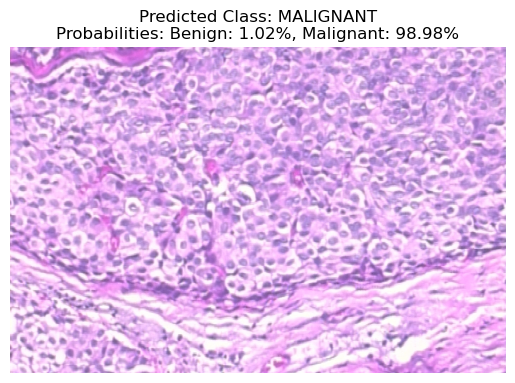

In [18]:
import joblib
from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.decomposition import PCA

# Load the saved VGG16 feature extractor model
vgg16_model_feature_extractor = load_model(r"C:\Users\K M SASTRY\Desktop\PROJECT\vgg16_feature_extractor.h5")

# Load the saved SVM classifier
svm_clf = joblib.load(r"C:\Users\K M SASTRY\Desktop\PROJECT\vgg_16_svm_classifier.pkl")

# Image preprocessing function
def preprocess_image(image_path, target_size):
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0  # Normalize the image
    return img_array

# Path to the input image (use an image from the test set)
img_path = r"K:\PROJECT\ORGANISED DATASET\test\MALIGNANT\mucinous_carcinoma\SOB_M_MC_14-13413\100X\SOB_M_MC-14-13413-100-036.png"  

# Preprocess the image
input_image = preprocess_image(img_path, target_size=(img_height, img_width))

# Extract features using the VGG16 feature extractor
features = vgg16_model_feature_extractor.predict(input_image)
features = features.reshape(1, -1)  # Reshape to fit SVM input

# Reduce dimensions using PCA
features_pca = pca.transform(features)

# Make predictions with the SVM
prediction = svm_clf.predict(features_pca)
prediction_proba = svm_clf.predict_proba(features_pca)

# Decode the predicted label
class_indices = train_generator.class_indices
class_labels = {v: k for k, v in class_indices.items()}
predicted_label = class_labels[prediction[0]]

# Format probabilities as percentages
prediction_proba_percent = prediction_proba[0] * 100

# Display the input image and prediction results
plt.imshow(load_img(img_path))
plt.axis('off')
plt.title(f"Predicted Class: {predicted_label}\n"
          f"Probabilities: Benign: {prediction_proba_percent[0]:.2f}%, "
          f"Malignant: {prediction_proba_percent[1]:.2f}%")
plt.show()


1/1 [==============================] - 0s 441ms/step


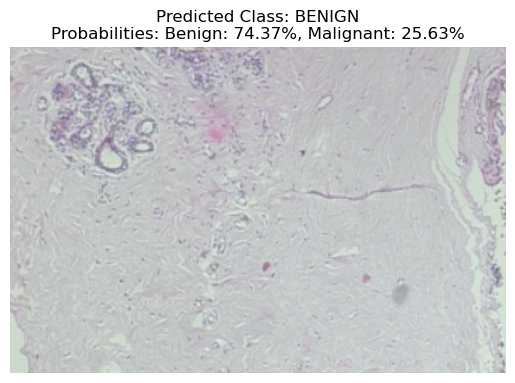

In [21]:
import joblib
from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.decomposition import PCA

# Load the saved VGG16 feature extractor model
vgg16_model_feature_extractor = load_model(r"C:\Users\K M SASTRY\Desktop\PROJECT\vgg16_feature_extractor.h5")

# Load the saved SVM classifier
svm_clf = joblib.load(r"C:\Users\K M SASTRY\Desktop\PROJECT\vgg_16_svm_classifier.pkl")

# Image preprocessing function
def preprocess_image(image_path, target_size):
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0  # Normalize the image
    return img_array

# Path to the input image (use an image from the test set)
img_path = r"K:\PROJECT\ORGANISED DATASET\test\BENIGN\adenosis\SOB_B_A_14-22549AB\40X\SOB_B_A-14-22549AB-40-003.png"

# Preprocess the image
input_image = preprocess_image(img_path, target_size=(img_height, img_width))

# Extract features using the VGG16 feature extractor
features = vgg16_model_feature_extractor.predict(input_image)
features = features.reshape(1, -1)  # Reshape to fit SVM input

# Reduce dimensions using PCA
features_pca = pca.transform(features)

# Make predictions with the SVM
prediction = svm_clf.predict(features_pca)
prediction_proba = svm_clf.predict_proba(features_pca)

# Decode the predicted label
class_indices = train_generator.class_indices
class_labels = {v: k for k, v in class_indices.items()}
predicted_label = class_labels[prediction[0]]

# Format probabilities as percentages
prediction_proba_percent = prediction_proba[0] * 100

# Display the input image and prediction results
plt.imshow(load_img(img_path))
plt.axis('off')
plt.title(f"Predicted Class: {predicted_label}\n"
          f"Probabilities: Benign: {prediction_proba_percent[0]:.2f}%, "
          f"Malignant: {prediction_proba_percent[1]:.2f}%")
plt.show()
